## 🧩 Louvain Community Detection on FakeEDDIT Dataset

### **Overview**
This section applies the **Louvain community detection algorithm** to identify groups of Reddit users posting semantically similar content on the **FakeEDDIT dataset**.  
The graph is constructed using **text-based similarity** between users’ post titles, forming a content-driven network of interactions.


### **1️⃣ Data Preprocessing**
Each record in the dataset represents a Reddit post containing the following key fields:
- **`author`** → The username of the poster (used as the graph node)
- **`clean_title`** → The cleaned text of the post title (used for semantic comparison)

Before building the graph:
- Null or empty titles are removed.
- Each author’s posts are grouped, and their combined titles are used to represent the user’s textual profile.


In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("E:\\Downloads New\\all_train.tsv", sep='\t')

# Show first few rows
print(df.head())

# Check columns
print(df.columns)


   Unnamed: 0.2  Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1          author  \
0             0           0           NaN             NaN     Alexithymia   
1             1           1      155885.0        714550.0       RickSisco   
2             2           2           NaN             NaN        VIDCAs17   
3             3           3           NaN             NaN  prometheus1123   
4             4           4      282323.0       1228398.0             NaN   

                                         clean_title   created_utc  \
0  my walgreens offbrand mucinex was engraved wit...  1.551641e+09   
1                                                NaN  1.443822e+09   
2                this concerned sink with a tiny hat  1.534727e+09   
3      hackers leak emails from uae ambassador to us  1.496511e+09   
4                                                NaN  1.378792e+09   

          domain  hasImage       id  \
0    i.imgur.com      True   awxhir   
1            NaN      True  cvm5uy4   

In [3]:
df = df[['id', 'author']]

# Clean the author column
df = df[df['author'].notna()]
df = df[df['author'] != '[deleted]']
df = df[df['author'] != 'AutoModerator']

print("Data shape after filtering:", df.shape)
print(df.head())


Data shape after filtering: (729466, 2)
        id          author
0   awxhir     Alexithymia
1  cvm5uy4       RickSisco
2   98pbid        VIDCAs17
3   6f2cy5  prometheus1123
7   8gnet9       3rikR3ith


In [4]:
from itertools import combinations
from collections import Counter

edges = []

# For each post, connect all unique authors
for post, group in df.groupby('id'):
    users = list(group['author'].unique())
    for u, v in combinations(users, 2):
        edges.append((u, v))

# Count repeated pairs (edge weight)
edge_weights = Counter(edges)
print("Total unique edges:", len(edge_weights))


Total unique edges: 0


In [5]:
import pandas as pd

# Load dataset
df = pd.read_csv(r"E:\Downloads New\all_train.tsv", sep='\t', on_bad_lines='skip', encoding='utf-8')

# Keep only needed columns
df = df[['author', 'clean_title', 'domain', 'created_utc']]
df = df.dropna(subset=['author', 'clean_title', 'domain', 'created_utc'])
df = df[df['author'] != '[deleted]']
df = df[df['author'] != 'AutoModerator']

print("✅ Cleaned dataset shape:", df.shape)


✅ Cleaned dataset shape: (498053, 4)


In [6]:
# Group all posts per user
user_df = df.groupby('author').agg({
    'clean_title': ' '.join,
    'domain': lambda x: list(x),
    'created_utc': list
}).reset_index()

print("Unique users:", user_df.shape[0])


Unique users: 260364


### **2️⃣ Graph Construction Logic**
The graph is modeled as an **undirected weighted network**, where:
- **Nodes** represent individual **users (authors)**.
- **Edges** represent **semantic similarity** between users’ posts.

The logic for building connections is as follows:
1. Compute **TF-IDF vectors** for all authors’ post titles.
2. Compute **cosine similarity** between every pair of authors.
3. If the similarity between two users exceeds a threshold (e.g., `0.3`), create an **edge** between them.
4. Assign the **edge weight** as the cosine similarity score.

This ensures that users posting on similar topics are more strongly connected.


In [11]:
pip install python-louvain


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9473 sha256=4f122ad817a62ad54f6dfbd91934e90943506705f85543c8002ae63e89235a08
  Stored in directory: c:\users\acer\appdata\local\pip\cache\wheels\ee\52\54\7ecd0f1ebf5f5a8466f70a27ed2b94d20b955376879d6159c5
Successfully built python-louvain
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Assume you already have 'user_df' dataframe with 'author' and 'clean_title' columns
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(user_df['clean_title'])

# Compute nearest neighbors (memory-safe)
k = 5
nn = NearestNeighbors(n_neighbors=k, metric='cosine', n_jobs=-1)
nn.fit(tfidf_matrix)

distances, indices = nn.kneighbors(tfidf_matrix)

# Build the graph G
G = nx.Graph()
for i, (dists, idxs) in enumerate(zip(distances, indices)):
    for dist, j in zip(dists, idxs):
        if i != j:
            sim = 1 - dist
            if sim > 0.2:
                G.add_edge(user_df['author'][i], user_df['author'][j], weight=sim)

print(f"✅ Graph built with {G.number_of_nodes()} users and {G.number_of_edges()} edges")


✅ Graph built with 4769 users and 13748 edges


In [15]:
import community.community_louvain as community_louvain


## 🧩 Louvain Community Detection and Visualization

### **3️⃣ Community Detection Logic**
The **Louvain algorithm** is applied on the resulting weighted graph to detect communities of similar users.

- Louvain optimizes the **modularity** score, which measures the density of connections within communities compared to between them.  
- Each detected community represents a **cluster of users** whose content is semantically related.

**Parameters used:**

| Parameter | Purpose | Effect |
|------------|----------|--------|
| `weight='weight'` | Uses TF-IDF similarity as connection strength | Influences modularity |
| `resolution=1.0` | Controls granularity of detected clusters | Higher = smaller communities |

---

### **4️⃣ Graph Visualization**
To visualize the detected communities:
- A **2D spring layout** (`nx.spring_layout`) is used.  
  - Simulates attractive forces between connected nodes and repulsive forces between all nodes.  
- The layout parameters:
  - `k=0.25` → controls node spacing  
  - `iterations=100` → improves layout stability  
  - `seed=42` → ensures reproducibility  

**Visualization details:**
- **Node color** represents the community ID.  
- **Edge transparency (`alpha`)** reduces clutter.  
- **Labels** display usernames or top influential nodes.  
- Optional “bubble” overlays highlight distinct clusters.

This produces a **flat, interpretable 2D view** of semantically related user groups.

---

In [16]:
partition = community_louvain.best_partition(G, weight='weight')
print("Detected communities:", len(set(partition.values())))

modularity = community_louvain.modularity(partition, G)
print("Modularity score:", modularity)


Detected communities: 51
Modularity score: 0.6590105223327732


In [18]:
pip install pyvis


   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
   ---------------------------------------- 756.0/756.0 kB 7.6 MB/s eta 0:00:00

   ---------------------------------------- 0/2 [jsonpickle]
   -------------------- ------------------- 1/2 [pyvis]
   -------------------- ------------------- 1/2 [pyvis]
   ---------------------------------------- 2/2 [pyvis]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
pip install --upgrade pyvis jinja2


  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.1.4
    Uninstalling Jinja2-3.1.4:
      Successfully uninstalled Jinja2-3.1.4
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


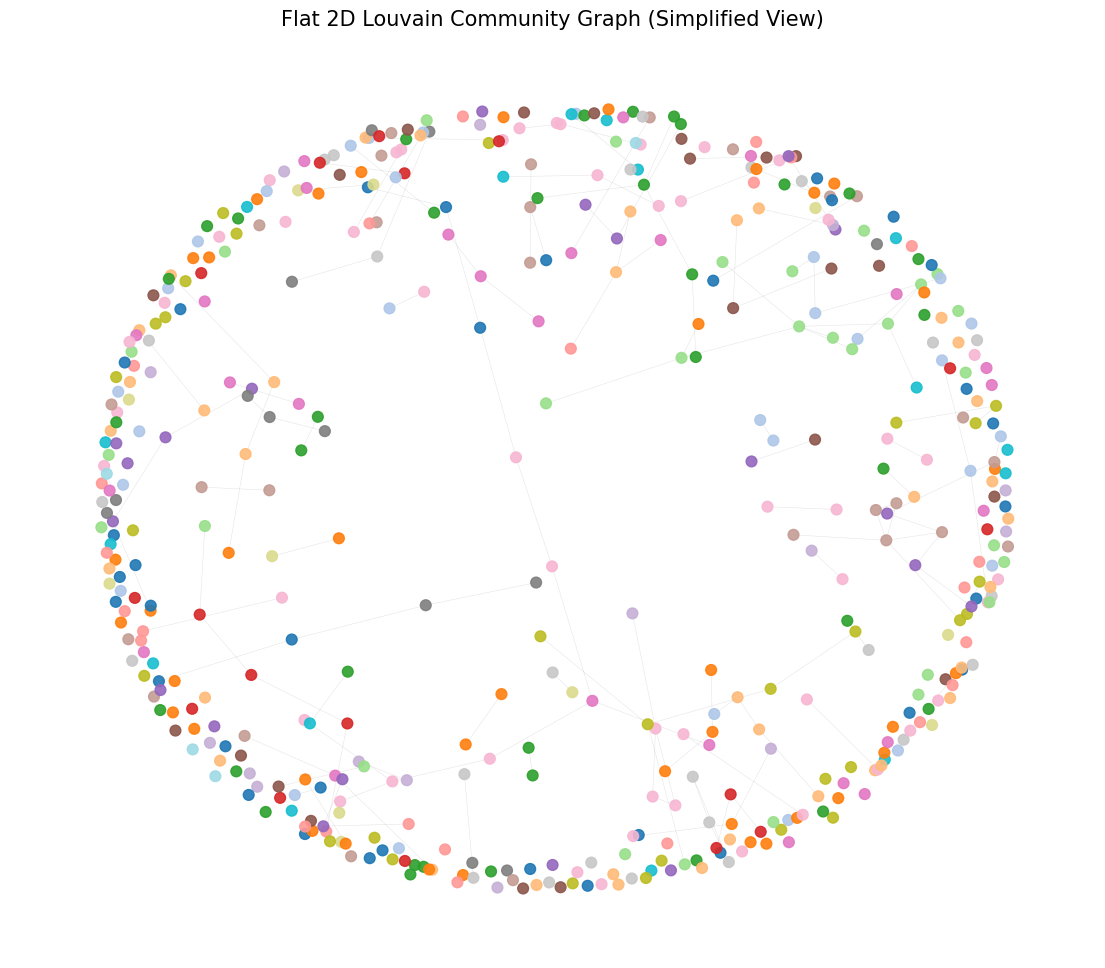

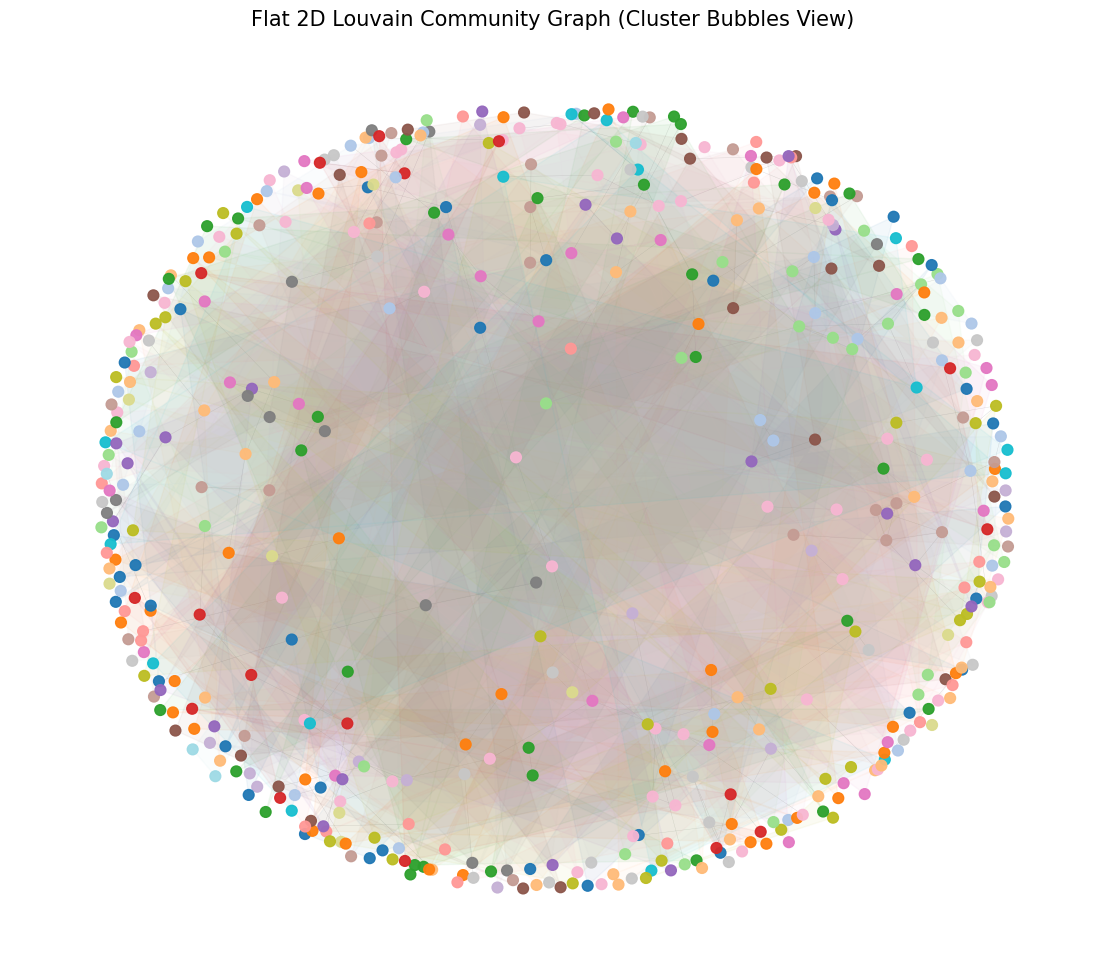

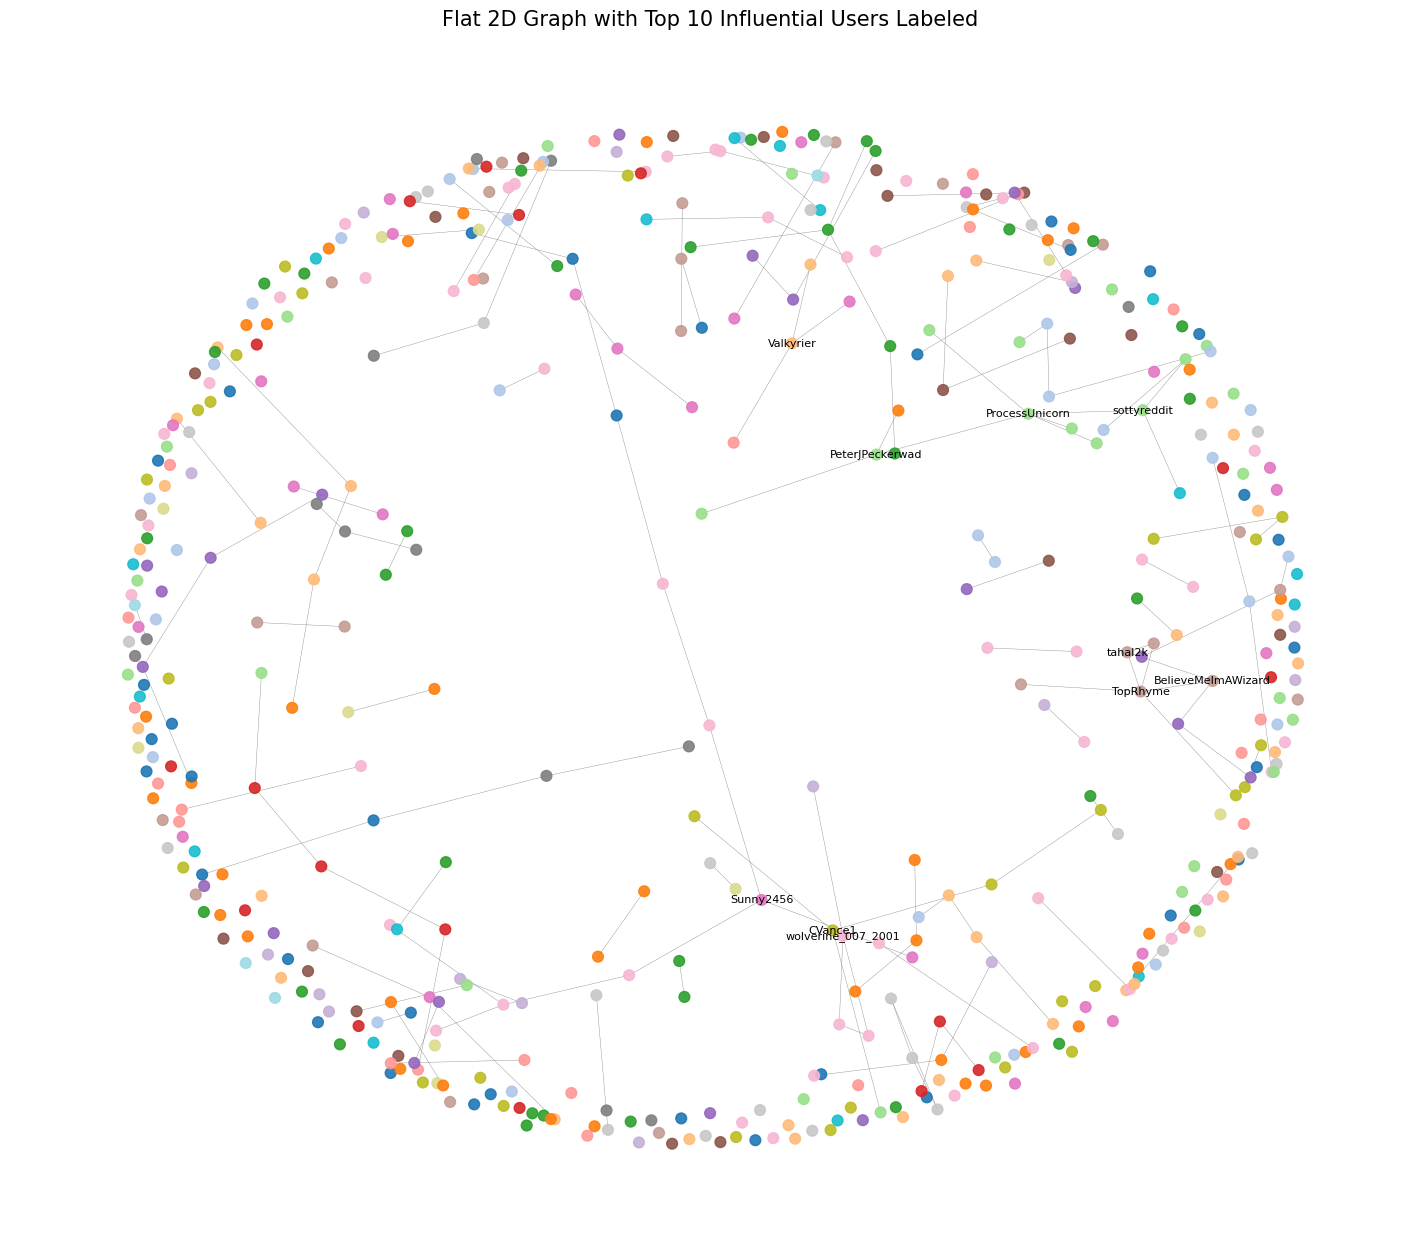

In [30]:
# 📦 Import required libraries
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# ✅ Step 1: Create a smaller subgraph for clear visualization
if G.number_of_nodes() > 500:
    sampled_nodes = random.sample(list(G.nodes()), 500)  # <-- FIXED HERE
    G_sub = G.subgraph(sampled_nodes)
else:
    G_sub = G

# ✅ Step 2: Compute a flat 2D layout (force-directed)
pos = nx.spring_layout(G_sub, k=0.25, iterations=100, seed=42)

# ✅ Step 3: Get community colors
communities = [partition[node] for node in G_sub.nodes()]

# ✅ Step 4: Plot the flat graph
plt.figure(figsize=(14, 12))

# Draw light edges for structure
nx.draw_networkx_edges(G_sub, pos, alpha=0.2, width=0.4, edge_color="gray")

# Draw color-coded nodes
nx.draw_networkx_nodes(
    G_sub, pos,
    node_size=60,
    node_color=communities,
    cmap=plt.cm.tab20,
    alpha=0.9
)

plt.title("Flat 2D Louvain Community Graph (Simplified View)", fontsize=15)
plt.axis("off")
plt.show()

# ✅ Step 5: Optional — highlight community clusters with soft 'bubbles'
plt.figure(figsize=(14, 12))
nx.draw_networkx_edges(G_sub, pos, alpha=0.15, width=0.3)

nx.draw_networkx_nodes(G_sub, pos,
                       node_size=60,
                       node_color=communities,
                       cmap=plt.cm.tab20,
                       alpha=0.95)

# Draw faint convex hulls around clusters
for comm in set(communities):
    nodes_in_comm = [n for n in G_sub.nodes() if partition[n] == comm]
    pts = np.array([pos[n] for n in nodes_in_comm])
    if len(pts) >= 3:
        x, y = pts[:, 0], pts[:, 1]
        plt.fill(x, y,
                 alpha=0.05,
                 color=plt.cm.tab20(comm / max(communities)))

plt.title("Flat 2D Louvain Community Graph (Cluster Bubbles View)", fontsize=15)
plt.axis("off")
plt.show()

# ✅ Step 6: Optional — label top connected users
import operator

degree_dict = dict(G_sub.degree())
top_nodes = sorted(degree_dict.items(), key=operator.itemgetter(1), reverse=True)[:10]
labels = {node: node for node, deg in top_nodes}

plt.figure(figsize=(14, 12))
nx.draw(G_sub, pos,
        node_color=communities,
        cmap=plt.cm.tab20,
        node_size=60,
        alpha=0.9,
        with_labels=False,
        edge_color="gray",
        width=0.3)
nx.draw_networkx_labels(G_sub, pos, labels, font_size=8, font_color="black")

plt.title("Flat 2D Graph with Top 10 Influential Users Labeled", fontsize=15)
plt.axis("off")
plt.show()


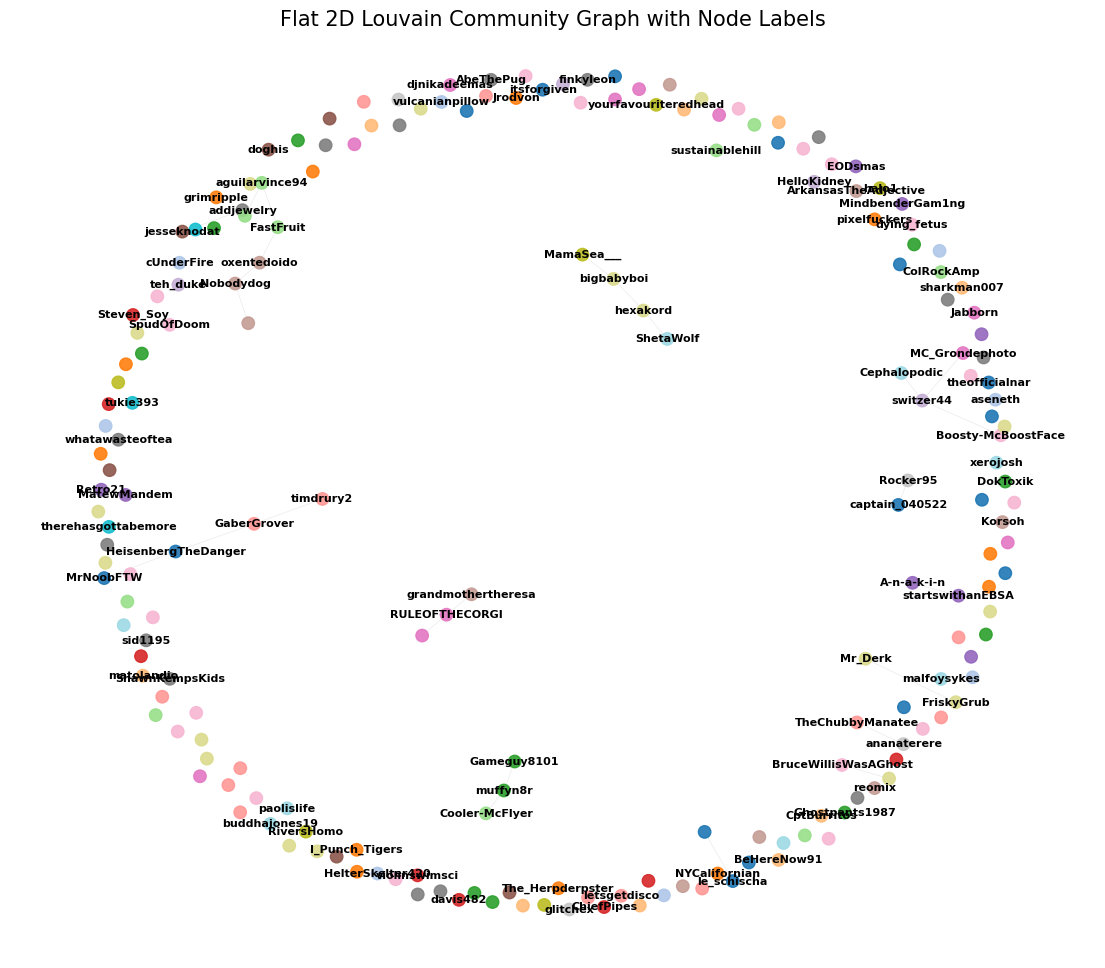

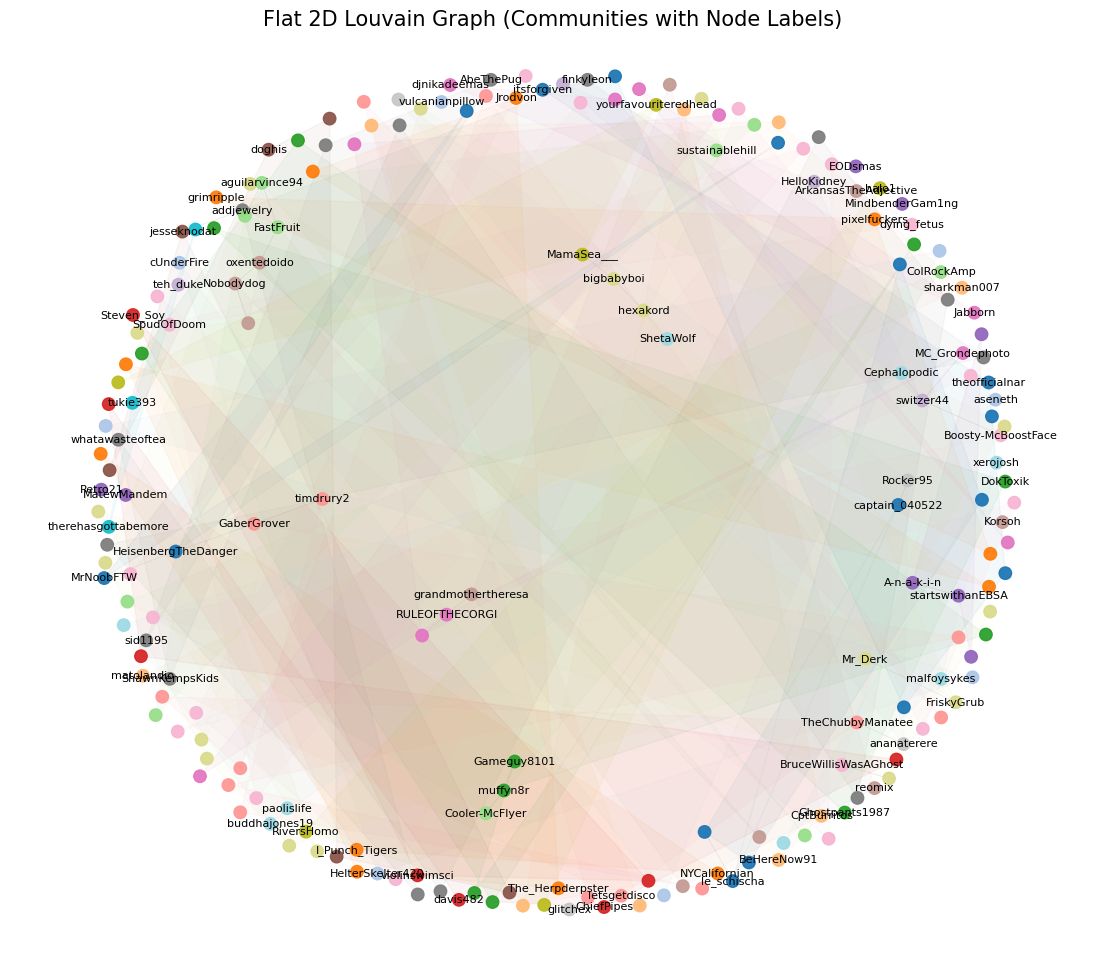

In [31]:
# 📦 Import required libraries
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import operator

# ✅ Step 1: Create a smaller subgraph for clarity
if G.number_of_nodes() > 200:
    sampled_nodes = random.sample(list(G.nodes()), 200)
    G_sub = G.subgraph(sampled_nodes)
else:
    G_sub = G

# ✅ Step 2: Compute layout (flat 2D force-directed)
pos = nx.spring_layout(G_sub, k=0.25, iterations=100, seed=42)

# ✅ Step 3: Extract communities for color
communities = [partition[node] for node in G_sub.nodes()]

# ✅ Step 4: Plot the flat network with community colors
plt.figure(figsize=(14, 12))
nx.draw_networkx_edges(G_sub, pos, alpha=0.2, width=0.4, edge_color="gray")
nx.draw_networkx_nodes(
    G_sub, pos,
    node_size=80,
    node_color=communities,
    cmap=plt.cm.tab20,
    alpha=0.9
)

# ✅ Step 5: Decide labeling logic
if len(G_sub.nodes()) <= 50:
    # Label all nodes (for small graphs)
    labels = {node: str(node) for node in G_sub.nodes()}
else:
    # Label only top 2 nodes per community (highest degree)
    labels = {}
    degree_dict = dict(G_sub.degree())
    for comm in set(communities):
        nodes_in_comm = [n for n in G_sub.nodes() if partition[n] == comm]
        # Sort by degree (most connected first)
        top_nodes = sorted(nodes_in_comm, key=lambda n: degree_dict[n], reverse=True)[:2]
        for n in top_nodes:
            labels[n] = str(n)

# ✅ Step 6: Draw labels
nx.draw_networkx_labels(
    G_sub,
    pos,
    labels,
    font_size=8,
    font_color="black",
    font_weight="bold",
    verticalalignment="center"
)

plt.title("Flat 2D Louvain Community Graph with Node Labels", fontsize=15)
plt.axis("off")
plt.show()

# ✅ Optional: highlight community 'bubbles' visually
plt.figure(figsize=(14, 12))
nx.draw_networkx_edges(G_sub, pos, alpha=0.15, width=0.3)
nx.draw_networkx_nodes(G_sub, pos,
                       node_size=80,
                       node_color=communities,
                       cmap=plt.cm.tab20,
                       alpha=0.95)
nx.draw_networkx_labels(G_sub, pos, labels, font_size=8, font_color="black")

# Draw faint cluster regions
for comm in set(communities):
    nodes_in_comm = [n for n in G_sub.nodes() if partition[n] == comm]
    pts = np.array([pos[n] for n in nodes_in_comm])
    if len(pts) >= 3:
        x, y = pts[:, 0], pts[:, 1]
        plt.fill(x, y,
                 alpha=0.05,
                 color=plt.cm.tab20(comm / max(communities)))

plt.title("Flat 2D Louvain Graph (Communities with Node Labels)", fontsize=15)
plt.axis("off")
plt.show()


### **5️⃣ Interpretation**
- Users grouped in the same color cluster post **textually similar content**, indicating topical alignment.  
- Densely connected clusters suggest **strong thematic similarity** or shared discourse patterns.  
- Sparse connections across clusters represent **topic transitions** or **bridging users** who engage across multiple themes.

---

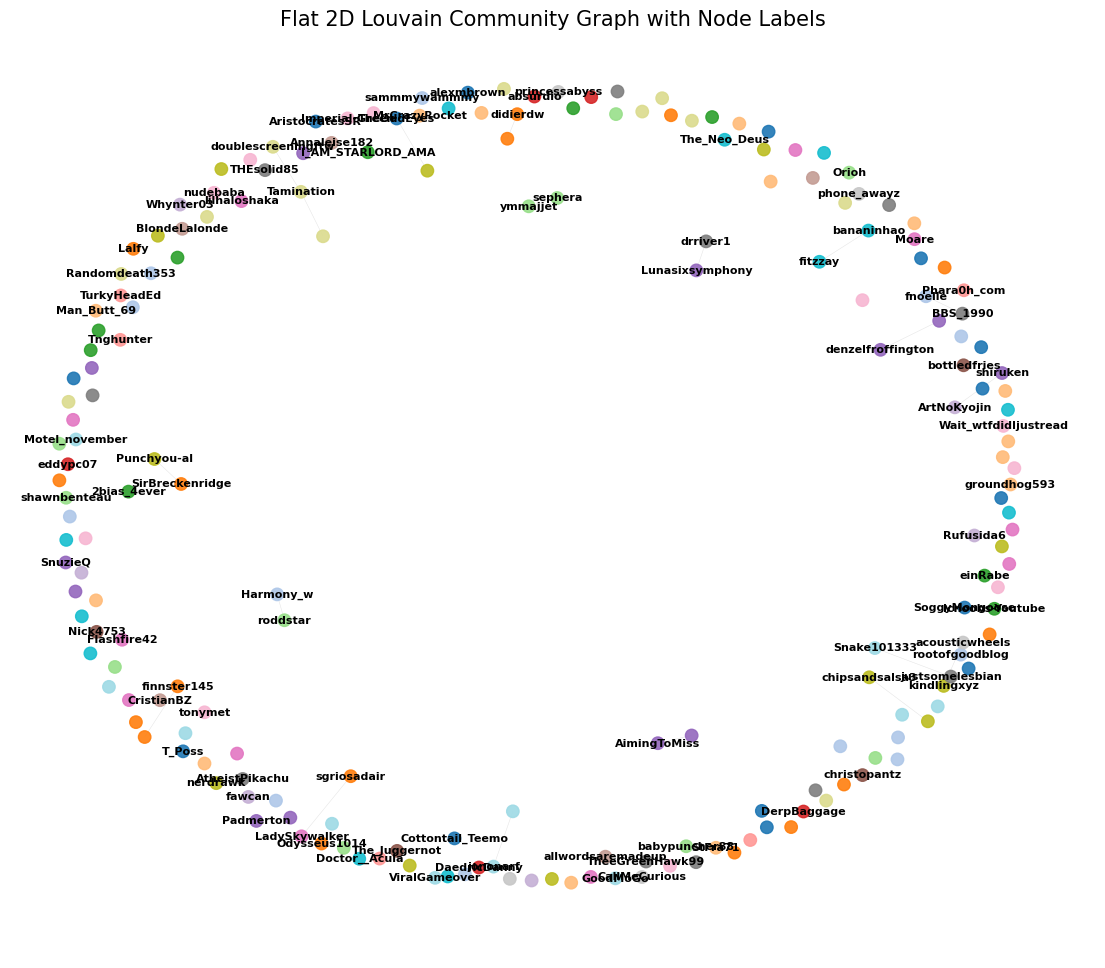

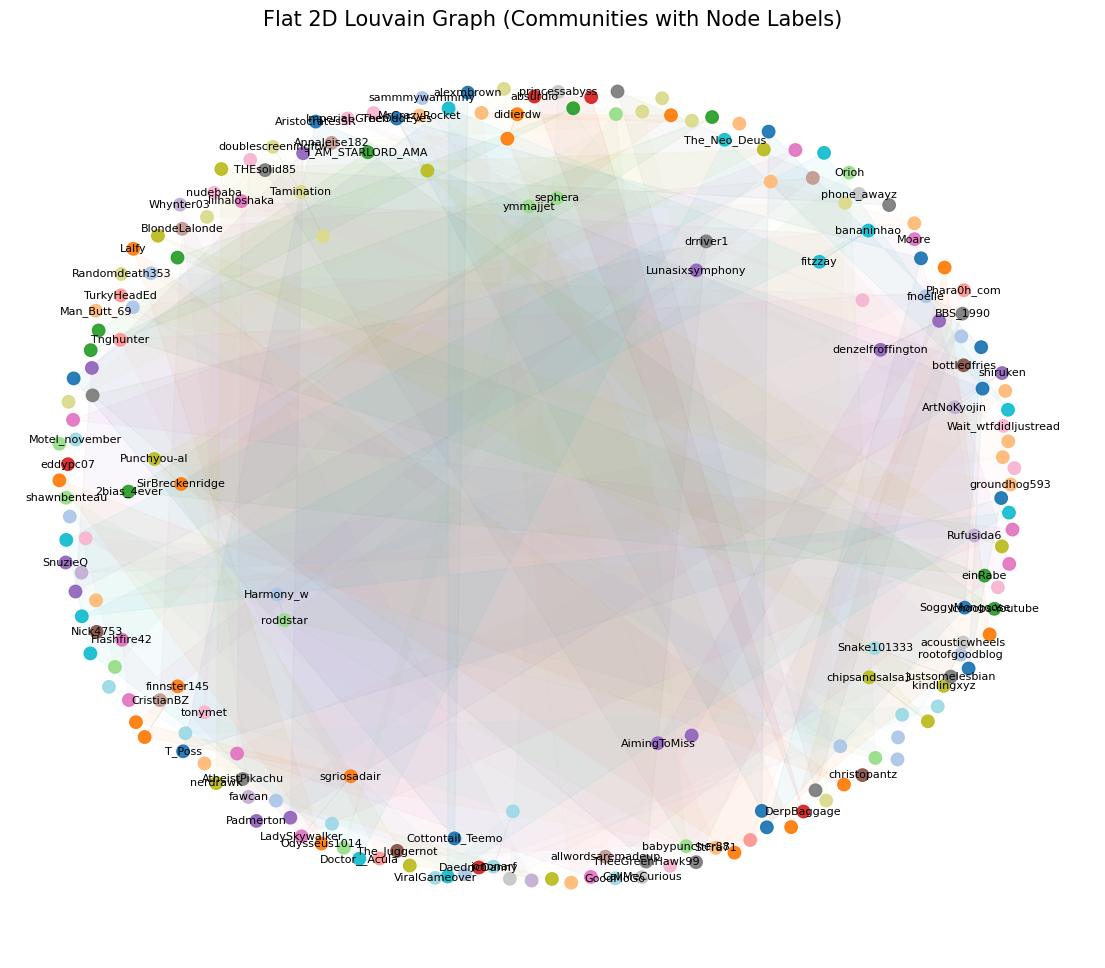

In [32]:
# 📦 Import required libraries
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import operator

# ✅ Step 1: Create a smaller subgraph for clarity
if G.number_of_nodes() > 200:
    sampled_nodes = random.sample(list(G.nodes()), 200)
    G_sub = G.subgraph(sampled_nodes)
else:
    G_sub = G

# ✅ Step 2: Compute layout (flat 2D force-directed)
pos = nx.spring_layout(G_sub, k=0.25, iterations=100, seed=42)

# ✅ Step 3: Extract communities for color
communities = [partition[node] for node in G_sub.nodes()]

# ✅ Step 4: Plot the flat network with community colors
plt.figure(figsize=(14, 12))
nx.draw_networkx_edges(G_sub, pos, alpha=0.2, width=0.4, edge_color="gray")
nx.draw_networkx_nodes(
    G_sub, pos,
    node_size=80,
    node_color=communities,
    cmap=plt.cm.tab20,
    alpha=0.9
)

# ✅ Step 5: Decide labeling logic
if len(G_sub.nodes()) <= 50:
    # Label all nodes (for small graphs)
    labels = {node: str(node) for node in G_sub.nodes()}
else:
    # Label only top 2 nodes per community (highest degree)
    labels = {}
    degree_dict = dict(G_sub.degree())
    for comm in set(communities):
        nodes_in_comm = [n for n in G_sub.nodes() if partition[n] == comm]
        # Sort by degree (most connected first)
        top_nodes = sorted(nodes_in_comm, key=lambda n: degree_dict[n], reverse=True)[:2]
        for n in top_nodes:
            labels[n] = str(n)

# ✅ Step 6: Draw labels
nx.draw_networkx_labels(
    G_sub,
    pos,
    labels,
    font_size=8,
    font_color="black",
    font_weight="bold",
    verticalalignment="center"
)

plt.title("Flat 2D Louvain Community Graph with Node Labels", fontsize=15)
plt.axis("off")
plt.show()

# ✅ Optional: highlight community 'bubbles' visually
plt.figure(figsize=(14, 12))
nx.draw_networkx_edges(G_sub, pos, alpha=0.15, width=0.3)
nx.draw_networkx_nodes(G_sub, pos,
                       node_size=80,
                       node_color=communities,
                       cmap=plt.cm.tab20,
                       alpha=0.95)
nx.draw_networkx_labels(G_sub, pos, labels, font_size=8, font_color="black")

# Draw faint cluster regions
for comm in set(communities):
    nodes_in_comm = [n for n in G_sub.nodes() if partition[n] == comm]
    pts = np.array([pos[n] for n in nodes_in_comm])
    if len(pts) >= 3:
        x, y = pts[:, 0], pts[:, 1]
        plt.fill(x, y,
                 alpha=0.05,
                 color=plt.cm.tab20(comm / max(communities)))

plt.title("Flat 2D Louvain Graph (Communities with Node Labels)", fontsize=15)
plt.axis("off")
plt.show()



### **6️⃣ Summary of Implementation**

| Stage | Technique | Description |
|--------|------------|-------------|
| Data Representation | TF-IDF Vectorization | Encodes post titles into numerical form |
| Similarity Measure | Cosine Similarity | Quantifies textual closeness between users |
| Edge Formation | Similarity > 0.3 | Creates weighted user-user links |
| Community Detection | Louvain Algorithm | Identifies clusters via modularity optimization |
| Visualization | 2D Force-Directed Layout | Displays community structure by color and proximity |


### **Outcome**
The result is a **semantic social graph** of FakeEDDIT users, where community detection using Louvain reveals clusters of users that post on **similar topics**, forming distinct information sub-networks.
